## Target Var analysis

The goal with this notebook is to see if there is significant value in predicting each of PCIAT_X values individually and then mapping them to sii; vs just predicting sii directly. The working theory is that PCIAT can act akin to a Neural Netork layer.

The way that we approach this is train two simple models for each approach to see which is better. The model trained (in this case RandomTreeClassifier) will be exactly the same between the two, everything will be exactly the same, the only thing that will be different is:

1. Baseline model: will predict sii directly (we ignore PCIAT as this results in data leakage!!! There is no PCIAT in test dataset, because our target value SII is predicted directly from them)
2. PCIAT model: will predict each PCIAT_X individually, and then map it (using previously determined thresholds) to sii. 

A simple metric will be used to compare the two models: accuracy score. 

As the goal is to compare the two approaches, I'm not doing anything too complicated yet like cross-validation etc. I'm also not using the time series data and for now training on all features.

In [110]:
# BORING HOUSEKEEPING STUFF 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")


pciat = train.loc[:, "PCIAT-Season":"PCIAT-PCIAT_Total"]
pciat["sii"] = train["sii"]

pciat_vals = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
       'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12',
       'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16',
       'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20']

In [111]:
file_path = 'all_na_ids.txt'

# Read the file and convert it to a list
with open(file_path, 'r') as file:
    lines = file.readlines()

# Remove newline characters and whitespace from each line
nas = [line.strip() for line in lines]

train = train[~train["id"].isin(nas)]
num_train = train.select_dtypes(include=['float64', 'int64'])

## Visualisation

Let's explore some correlations so that we can get an idea visually if it's worth it.

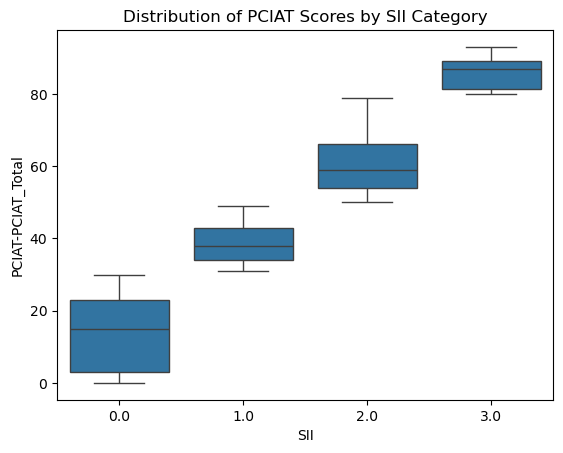

In [12]:
# Mapping of sii to total: just to show there's no overlap

import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=train)
plt.title('Distribution of PCIAT Scores by SII Category')
plt.xlabel('SII')
plt.ylabel('PCIAT-PCIAT_Total')
plt.show()

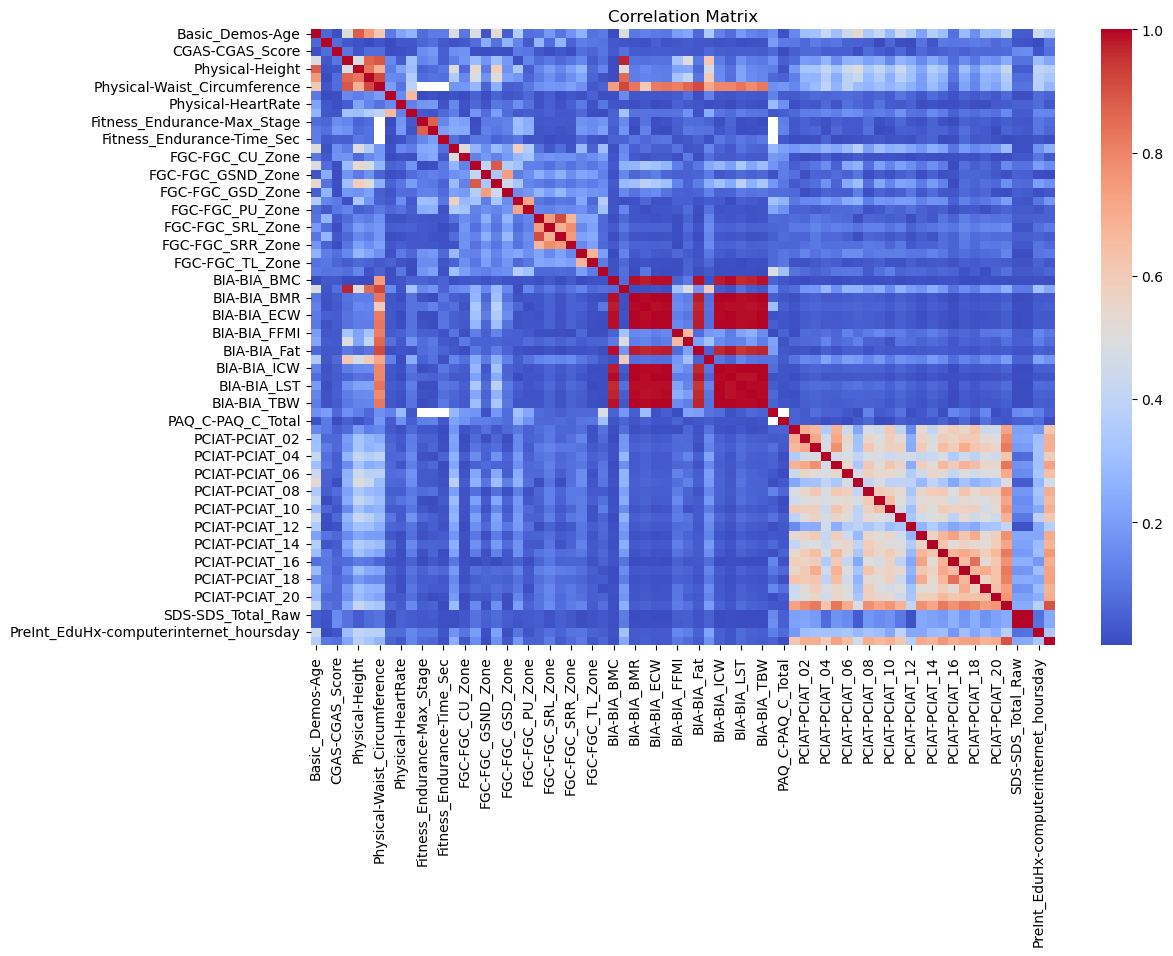

In [37]:
# Correlation heatmap among all variables

corr_matrix = num_train.corr()

for col in corr_matrix.columns:
    corr_matrix[col] = abs(corr_matrix[col])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

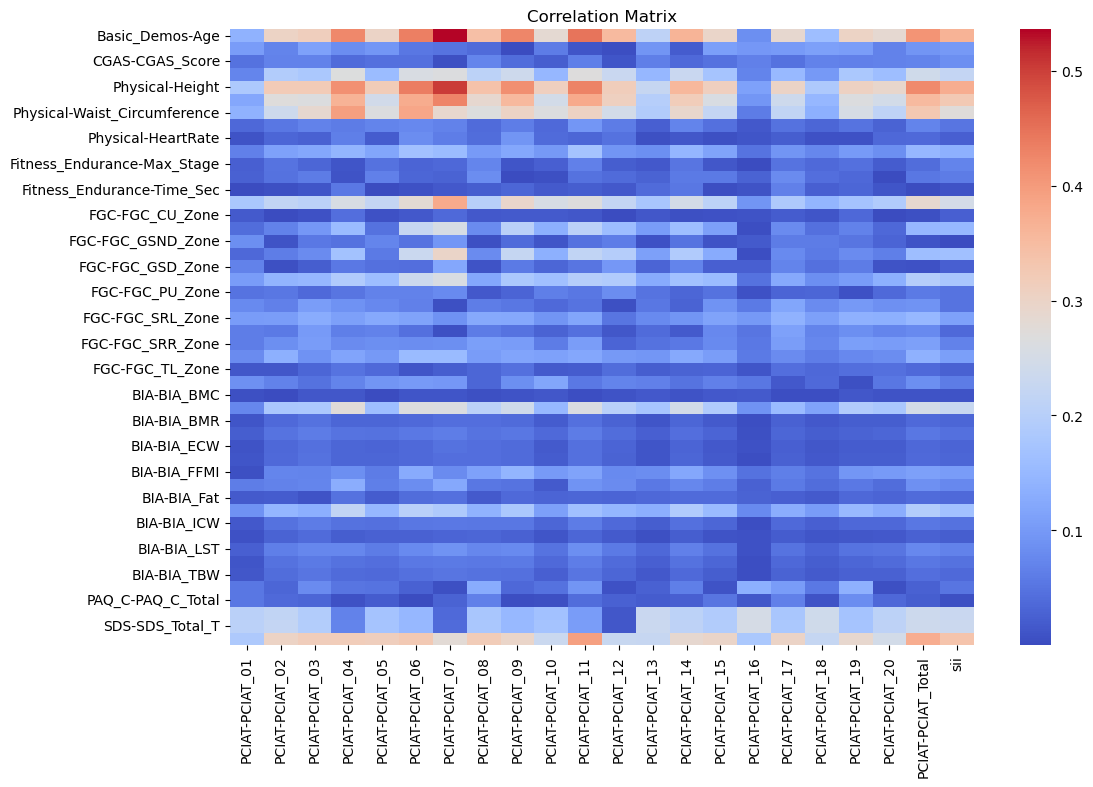

In [60]:
# Correlation heatmap between PCIAT & all variables

corr_matrix3 = corr_matrix.drop(index=pciat.columns.drop("PCIAT-Season"))
corr_matrix3 = corr_matrix3.loc[:,pciat.columns.drop("PCIAT-Season")]
corr_matrix3.shape

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix3, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PCIAT-Season       2736 non-null   object 
 1   PCIAT-PCIAT_01     2733 non-null   float64
 2   PCIAT-PCIAT_02     2734 non-null   float64
 3   PCIAT-PCIAT_03     2731 non-null   float64
 4   PCIAT-PCIAT_04     2731 non-null   float64
 5   PCIAT-PCIAT_05     2729 non-null   float64
 6   PCIAT-PCIAT_06     2732 non-null   float64
 7   PCIAT-PCIAT_07     2729 non-null   float64
 8   PCIAT-PCIAT_08     2730 non-null   float64
 9   PCIAT-PCIAT_09     2730 non-null   float64
 10  PCIAT-PCIAT_10     2733 non-null   float64
 11  PCIAT-PCIAT_11     2734 non-null   float64
 12  PCIAT-PCIAT_12     2731 non-null   float64
 13  PCIAT-PCIAT_13     2729 non-null   float64
 14  PCIAT-PCIAT_14     2732 non-null   float64
 15  PCIAT-PCIAT_15     2730 non-null   float64
 16  PCIAT-PCIAT_16     2728 

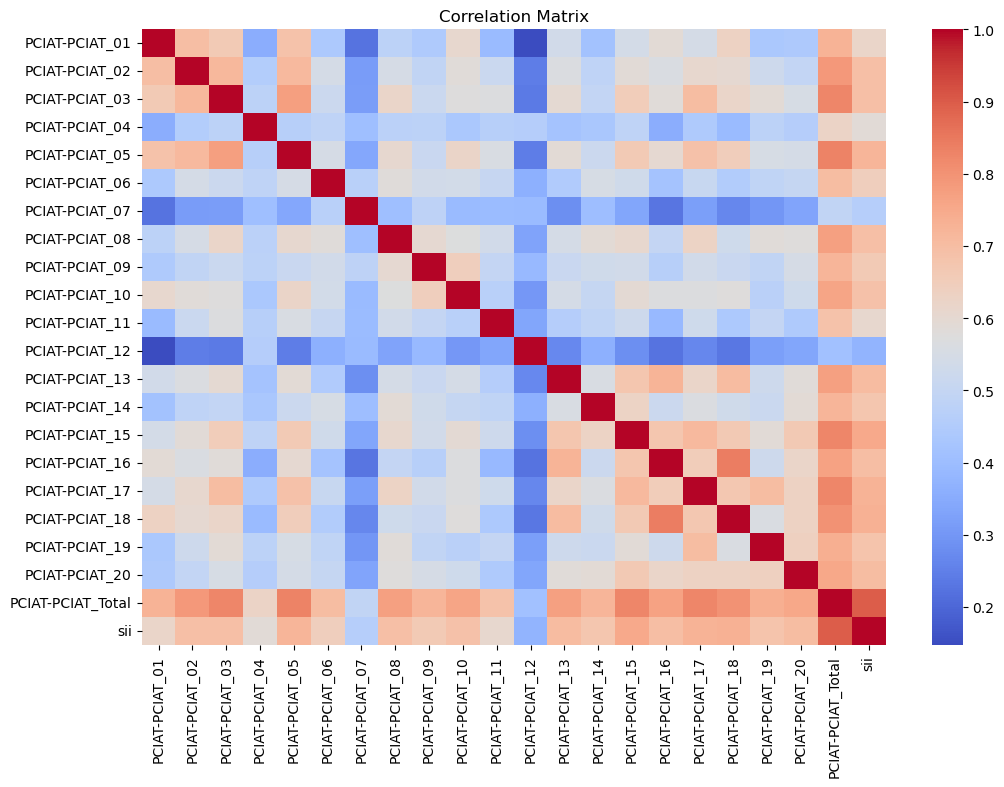

In [24]:
# Correlation matrix between PCIAT values

pciat.info()
num_pciat = pciat.select_dtypes(include=['float64', 'int64'])

corr_matrix2 = num_pciat.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix2, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Model training 
As above - training some simple models, keeping everything else exactly the same, the only difference is target variable is sii vs PCIAT_X. 

I'm using Decision Tree Classifier and converting NAs to -999 so that we're able to work with NAs natively instead of just dropping them

In [122]:
# Baseline model: 
import time 
from sklearn.metrics import f1_score

pciat_vals = pciat.columns.drop(['PCIAT-Season', 'sii'])
df1 = num_train.drop(pciat_vals, axis=1)

for col in df1.columns:
    df1[col] = df1[col].fillna(-999)

time1=time.time()
# Split data
X = df1.drop('sii', axis=1)
y = df1['sii']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Train model
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
time2=time.time()

print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

print(f"time: {time2-time1} sec")

0.5275082965665991
              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72       478
         1.0       0.33      0.26      0.29       219
         2.0       0.25      0.24      0.24       114
         3.0       0.00      0.00      0.00        10

    accuracy                           0.54       821
   macro avg       0.31      0.31      0.31       821
weighted avg       0.52      0.54      0.53       821

time: 0.0994880199432373 sec


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The **baseline model** of decision tree classifier achieved the accuracy of 0.709 in 0.0455 sec

In [119]:
# by-PCIAT model: predict each PCIAT_X from all features, then map to sii 

# define model

def predict_pciat_sii(data):
    time1 = time.time()
    pciat_vals = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
       'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12',
       'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16',
       'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20']
    train, test = train_test_split(data, test_size=0.3, random_state=42)
    train1 = train.dropna(subset=pciat_vals)
    test1 = test.dropna(subset=pciat_vals)
    train2 = train1.drop("sii", axis=1).dropna(subset=pciat_vals).select_dtypes(include=['float64', 'int64'])
    test2 = test1.drop("sii", axis=1).dropna(subset=pciat_vals).select_dtypes(include=['float64', 'int64'])
    # data = data.drop("sii", axis=1).dropna(subset=pciat_vals)
    
    # print(train.columns)
    # print(test.columns)
    pciat_pred = pd.DataFrame(index=range(test1.shape[0]))
    for val in pciat_vals:
        other_vals = [x for x in pciat_vals if x != val]
        # print(other_vals)
        train3 = train2.drop(other_vals, axis=1)
        test3 = test2.drop(other_vals, axis=1)
        X_train = train3.drop(val, axis=1)
        X_test = test3.drop(val, axis=1)
        y_train = train3[val]
        y_test = test3[val]
        # X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=42)
        model = DecisionTreeClassifier(max_depth=5, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        pciat_pred[val] = y_pred
    time2 = time.time()
    print(f"time to run: {time2-time1} sec")
    return pciat_pred, test1




In [120]:
# train & test by-PCIAT model 

pciat_pred, test = predict_pciat_sii(train)

pciat_pred["total"]=pciat_pred[pciat_pred.columns].sum(axis=1)

# map total to sii

def cat_sii(val):
    if 0 <= val <= 30:
        return 0.0
    elif 31 <= val <= 49:
        return 1.0
    elif 50 <= val <= 79:
        return 2.0
    else: 
        return 3.0

pciat_pred['sii'] = pciat_pred['total'].apply(cat_sii)

y_test = test['sii']
# accuracy_score(test['sii'], pciat_pred['sii'])
f1_score(test['sii'], pciat_pred['sii'], average='weighted')

time to run: 1.6878080368041992 sec


0.9134230089288639

So the accuracy of the PCIAT_X model, keeping everything else the same, is 0.93 - a massive gain compared to basal model!!!

In [81]:
# QC

# Check that the only predicted values for each PCIAT_X are 0 to 5

for col in pciat_pred.columns:
    print(f"{col}: {min(pciat_pred[col])}-{max(pciat_pred[col])}")

# check that total is sorted into sii correctly
sii_vals = [0.0, 1.0, 2.0, 3.0]
for val in sii_vals:
    pciat_vals = np.sort(pciat_pred[pciat_pred["sii"]==val]["total"].unique())
    print(f"sii {val}: PCIAT range {min(pciat_vals)}-{max(pciat_vals)}")

PCIAT-PCIAT_01: 0.0-5.0
PCIAT-PCIAT_02: 0.0-5.0
PCIAT-PCIAT_03: 0.0-5.0
PCIAT-PCIAT_04: 0.0-5.0
PCIAT-PCIAT_05: 0.0-5.0
PCIAT-PCIAT_06: 0.0-5.0
PCIAT-PCIAT_07: 0.0-4.0
PCIAT-PCIAT_08: 0.0-5.0
PCIAT-PCIAT_09: 0.0-5.0
PCIAT-PCIAT_10: 0.0-5.0
PCIAT-PCIAT_11: 0.0-5.0
PCIAT-PCIAT_12: 0.0-2.0
PCIAT-PCIAT_13: 0.0-5.0
PCIAT-PCIAT_14: 0.0-5.0
PCIAT-PCIAT_15: 0.0-5.0
PCIAT-PCIAT_16: 0.0-5.0
PCIAT-PCIAT_17: 0.0-5.0
PCIAT-PCIAT_18: 0.0-5.0
PCIAT-PCIAT_19: 0.0-5.0
PCIAT-PCIAT_20: 0.0-5.0
total: 0.0-91.0
sii: 0.0-3.0
sii 0.0: PCIAT range 0.0-30.0
sii 1.0: PCIAT range 31.0-49.0
sii 2.0: PCIAT range 50.0-79.0
sii 3.0: PCIAT range 80.0-91.0


## Conclusion:

Basal model accuracy: 0.708, PCIAT model accuracy: 0.931
A massive gain in accuracy! 